# Tick Classification Inference Pipeline
This notebook provides a simple pipeline to load the trained model weights and run predictions on new images.

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


from model import get_model
import os

## 1. Setup Configuration
Define the classes and the device to use for inference.

In [2]:
CLASSES = ['hyalomma_female', 'hyalomma_male', 'rhipicephalus_female', 'rhipicephalus_male']
MODEL_PATH = 'tick_model.pth'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


## 2. Load Model
Initialize the architecture and load the saved state dictionary.

In [3]:
def load_trained_model(model_path, device):
    # We use resnet18 as defined in model.py
    model = get_model('resnet18', num_classes=len(CLASSES), pretrained=False)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

model = load_trained_model(MODEL_PATH, DEVICE)
print("Model loaded successfully!")

d:\projects\tick_classification_model\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\projects\tick_classification_model\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded successfully!


## 3. Image Preprocessing
Define the transformations required for the input image (same as validation transformations).

In [4]:
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## 4. Prediction Function
The core function that takes an image path and returns the predicted label and confidence.

In [5]:
def predict_tick(image_path, model, transform, device, classes):
    # Load image
    image = Image.open(image_path).convert('RGB')
    
    # Apply transforms and add batch dimension
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
        confidence, predicted_idx = torch.max(probabilities, 0)
        
    label = classes[predicted_idx.item()]
    score = confidence.item() * 100
    
    return label, score, image

def display_prediction(image_path):
    label, confidence, img = predict_tick(image_path, model, inference_transform, DEVICE, CLASSES)
    
    plt.imshow(img)
    plt.title(f"Prediction: {label} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()
    
    print(f"Image: {os.path.basename(image_path)}")
    print(f"Predicted Label: {label}")
    print(f"Confidence: {confidence:.2f}%")

## 5. Run Prediction
Point to any image file to see the result.

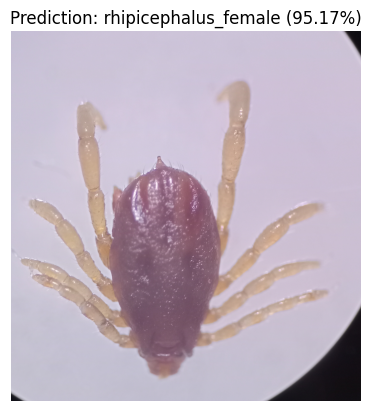

Image: IMG_20250728_215627.jpg
Predicted Label: rhipicephalus_female
Confidence: 95.17%


In [27]:
# Example usage with an image from your dataset
sample_image = r'D:\projects\tick_classification_model\Tick-20260131T070319Z-3-001\Tick\Rhipicephalus\Rhipicephalus microplus\Rhipicephalus microplus _ Male\IMG_20250728_215627.jpg'

if os.path.exists(sample_image):
    display_prediction(sample_image)
else:
    print("Please provide a valid image path.")